In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [24]:
df = pd.read_csv('./kaggle/bike/train.csv')
# df['datetime'] = df['datatime'].apply(pd.to_datetime)
df['datetime'] = pd.to_datetime(df['datetime'])

# df['year'] = df['datetime'].apply(lambda x: x.year)
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

df.drop(['datetime', 'casual', 'registered'], axis=1, inplace=True)

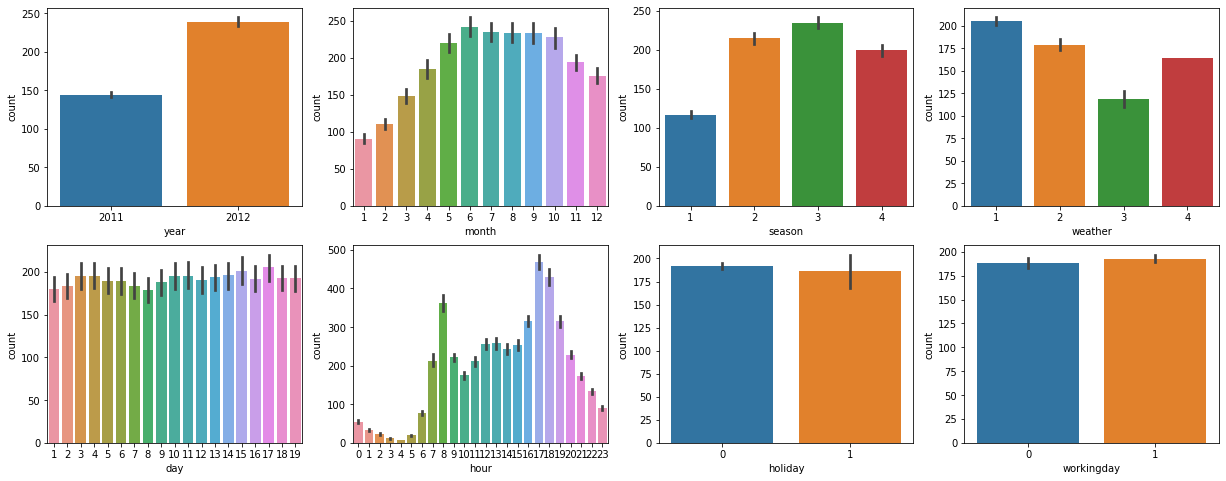

In [34]:
fig,axes = plt.subplots(figsize=(21, 8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']
for i, f in enumerate(cat_features):
    row = int(i / 4)
    col = i % 4
    sns.barplot(x=f, y='count', data=df, ax=axes[row][col])
    # plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45)
    # axes[row][col].set_xticklabels(axes[row][col].get_xticklabels(), rotation=45)
    

In [63]:
def rmsle(Y, pred):
    log_Y = np.log1p(Y)
    log_pred = np.log1p(pred)
    squared_error = (log_Y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(Y, pred):
    return np.sqrt(mean_squared_error(Y, pred))

def evaluate_regr(Y, pred):
    rmsle_val = rmsle(Y, pred)
    rmse_val = rmse(Y, pred)
    mae_val = mean_absolute_error(Y, pred)
    print('RMSLE: {:.3f}, RMSE: {:.3f}, MAE: {:.3f}'.format(rmsle_val, rmse_val, mae_val))

def get_top_error_data(Y_test, pred, n_tops=5):
    df = pd.DataFrame(Y_test.values, columns=['real_count'])
    df['predicted_count'] = np.round(pred)
    df['diff'] = np.abs(df['real_count'] - df['predicted_count'])
    print(df.sort_values('diff', ascending=False)[: n_tops])

def get_model_predict(model, X_train, X_test, Y_train, Y_test, is_expm1=False):
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    if is_expm1:
        Y_test = np.expm1(Y_test)
        pred = np.expm1(pred)
    print('\n', model.__class__.__name__)
    evaluate_regr(Y_test, pred)


In [60]:
Y = df['count']
X = df.drop(['count'], axis=1, inplace=False)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
get_model_predict(lr_reg, X_train, X_test, Y_train, Y_test)
# lr_reg.fit(X_train, Y_train)
# pred = lr_reg.predict(X_test)
# evaluate_regr(Y_test, pred)
# get_top_error_data(Y_test, pred, n_tops=5)

LinearRegression
RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


<AxesSubplot:>

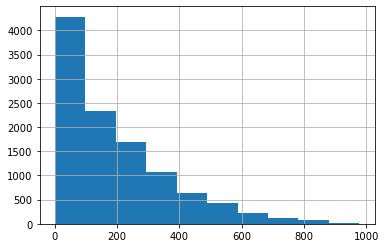

In [46]:
Y.hist()

<AxesSubplot:>

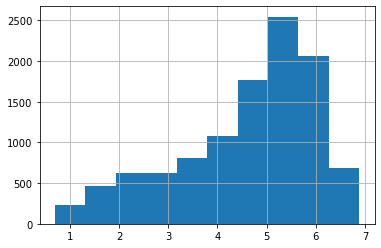

In [48]:
Y_log = np.log1p(Y)
Y_log.hist()

LinearRegression
RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<AxesSubplot:>

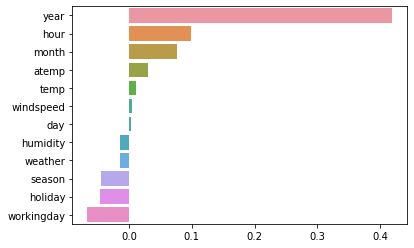

In [61]:
Y = df['count']
X = df.drop(['count'], axis=1, inplace=False)
Y_log = np.log1p(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
get_model_predict(lr_reg, X_train, X_test, Y_train, Y_test, True)

# lr_reg.fit(X_train, Y_train)
# pred = lr_reg.predict(X_test)

# Y_test_exp = np.expm1(Y_test)
# pred_exp = np.expm1(pred)


# evaluate_regr(Y_test_exp, pred_exp)
# get_top_error_data(Y_test, pred, n_tops=5)

coef = pd.Series(lr_reg.coef_, index=X.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

RMSLE: 0.142, RMSE: 0.590, MAE: 0.441


<AxesSubplot:>

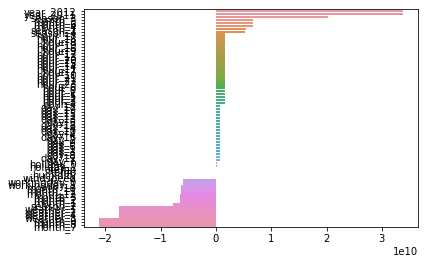

In [58]:
Y = df['count']
Y_log = np.log1p(Y)
X = df.drop(['count'], axis=1, inplace=False)
X_ohe = pd.get_dummies(X, columns=['year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather'])
X_train, X_test, Y_train, Y_test = train_test_split(X_ohe, Y_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, Y_train)
pred = lr_reg.predict(X_test)
evaluate_regr(Y_test, pred)
# get_top_error_data(Y_test, pred, n_tops=5)

coef = pd.Series(lr_reg.coef_, index=X_ohe.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)


 LinearRegression
RMSLE: 0.590, RMSE: 97.687, MAE: 63.382


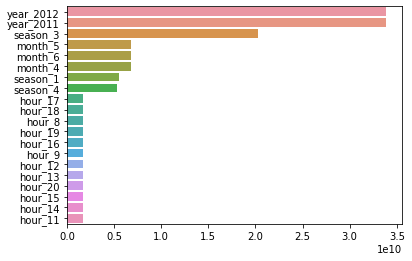


 Ridge
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893


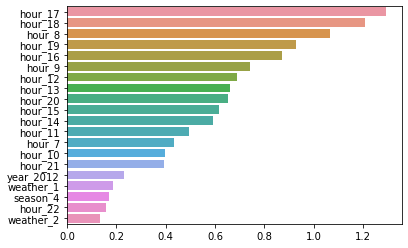


 Lasso
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


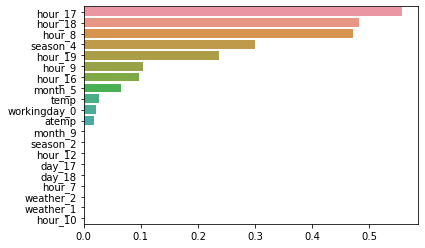

In [72]:
Y = df['count']
Y_log = np.log1p(Y)
X = df.drop(['count'], axis=1, inplace=False)
X_ohe = pd.get_dummies(X, columns=['year', 'month', 'day', 'hour', 'season', 'holiday', 'workingday', 'weather'])
X_train, X_test, Y_train, Y_test = train_test_split(X_ohe, Y_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, Y_train, Y_test, True)
    
    coef = pd.Series(model.coef_, index=X_ohe.columns)
    coef_sort = coef.sort_values(ascending=False)[:20]
    sns.barplot(x=coef_sort.values, y=coef_sort.index)
    
    plt.show()


In [78]:
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, Y_train.values, Y_test.values, True)


 RandomForestRegressor
RMSLE: 0.355, RMSE: 50.541, MAE: 31.219

 GradientBoostingRegressor
RMSLE: 0.330, RMSE: 53.340, MAE: 32.744

 XGBRegressor
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251

 LGBMRegressor
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


In [47]:
a = 10
result = np.log1p(a)
res = np.expm1(result)
print(result, res)   # log1p 로 1을 더해서 로그를 취해도 expm1로 1을 뺀 원래 값을 구할 수 있다

2.3978952727983707 10.000000000000002
